## **Installations & Imports**

In [30]:
%pip install pandas
%pip install yfinance
%pip install scikit-learn
%pip install projectpro


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [31]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

import yfinance as yf

import keras
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import os 

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.layers import LSTM, SimpleRNN
from keras.models import Sequential
from keras.layers import Dense

from projectpro import model_snapshot, checkpoint

In [32]:
keras.backend.set_image_data_format("channels_last")
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
yf.pdr_override()
%matplotlib inline

## **Time Series Data**

### Retreive Data

In [33]:
now = datetime(2023, 11, 1)
dataset = yf.download('NVDA', now - relativedelta(years=5), now)
print(dataset)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-11-01   53.075001   54.622501   51.797501   54.527500   54.049877   
2018-11-02   54.432499   55.500000   52.552502   53.730000   53.259357   
2018-11-05   53.597500   53.832500   51.320000   52.942501   52.478752   
2018-11-06   52.862499   53.712502   52.389999   52.764999   52.302818   
2018-11-07   53.437500   54.352501   52.794998   53.447498   52.979324   
...                ...         ...         ...         ...         ...   
2023-10-25  433.980011  436.500000  415.549988  417.790009  417.753265   
2023-10-26  418.529999  422.559998  398.799988  403.260010  403.224548   
2023-10-27  411.299988  412.059998  400.149994  405.000000  404.964386   
2023-10-30  410.869995  417.660004  404.809998  411.609985  411.573792   
2023-10-31  404.500000  408.790009  392.299

### Partition Training & Testing Set

In [34]:
def train_test_split(dataset, end, columns=['Close']):
    start_train = end - relativedelta(years=6)
    end_train = start_train + relativedelta(years=4)

    start_test = end - relativedelta(years=2)
    end_test = end

    train = dataset.loc[start_train:end_train, columns].values
    test = dataset.loc[start_test:end_test, columns].values
    
    return train, test


In [35]:
train_set, test_set = train_test_split(dataset, datetime(2023, 12, 31))

In [36]:
def train_test_plot(train_set, test_set):
    plt.figure(figsize=(16, 4))
    plt.plot(train_set, label=f"Train (Before {test_set[0][0]})")
    plt.plot(range(len(train_set), len(train_set) + len(test_set)), test_set, label=f"Test ({test_set[0][0]} and beyond)")
    plt.legend()
    plt.title("Stock Price")
    plt.show()

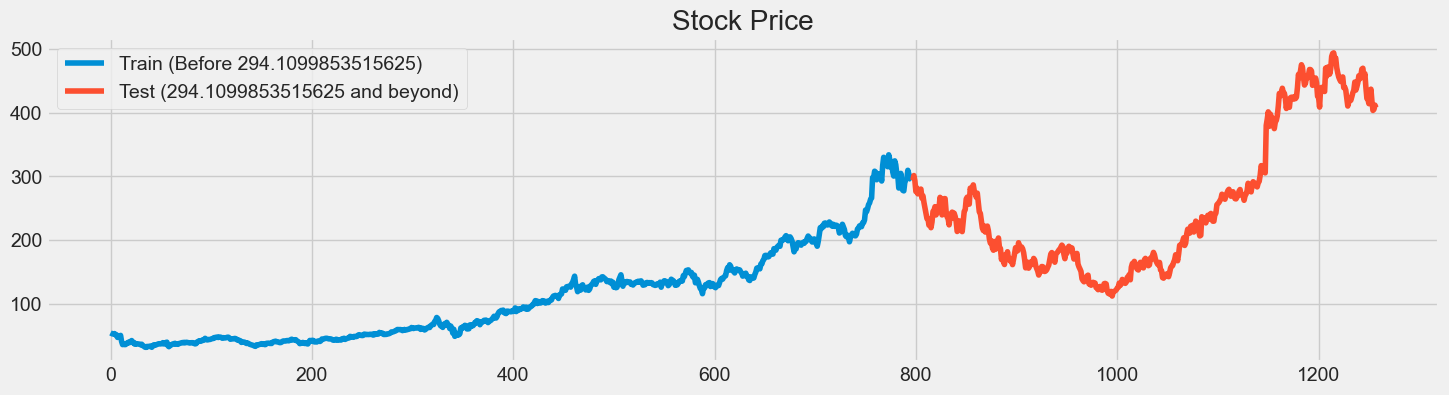

In [37]:
train_test_plot(train_set, test_set)

### Scaling Data Set 

In [38]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = train_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

### Windows

In [39]:
n_steps = 1
features = 1

In [40]:
# Split sequence of data into input-output pairs consisteing of n_seps
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [41]:
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [42]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)

### Evaluation

In [43]:
def plot_predictions(test, predicted, title):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title(f'{title}')
    plt.xlabel("Time")
    plt.ylabel(f'{title}')
    plt.legend()
    plt.show()

In [44]:
def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

## **RNN**

### Set Up

In [45]:
def plot_loss(history):
    plt.figure(figsize = (15,10))
    plt.plot(history.history['loss'], label='loss')
    plt.legend(loc='best')
    plt.show()

In [46]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=125, input_shape=(n_steps, features)))
model_rnn.add(Dense(units=1))

In [47]:
# Compiling the model
model_rnn.compile(optimizer="RMSprop", loss="mse")

In [48]:
history = model_rnn.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
model_snapshot("34db30")

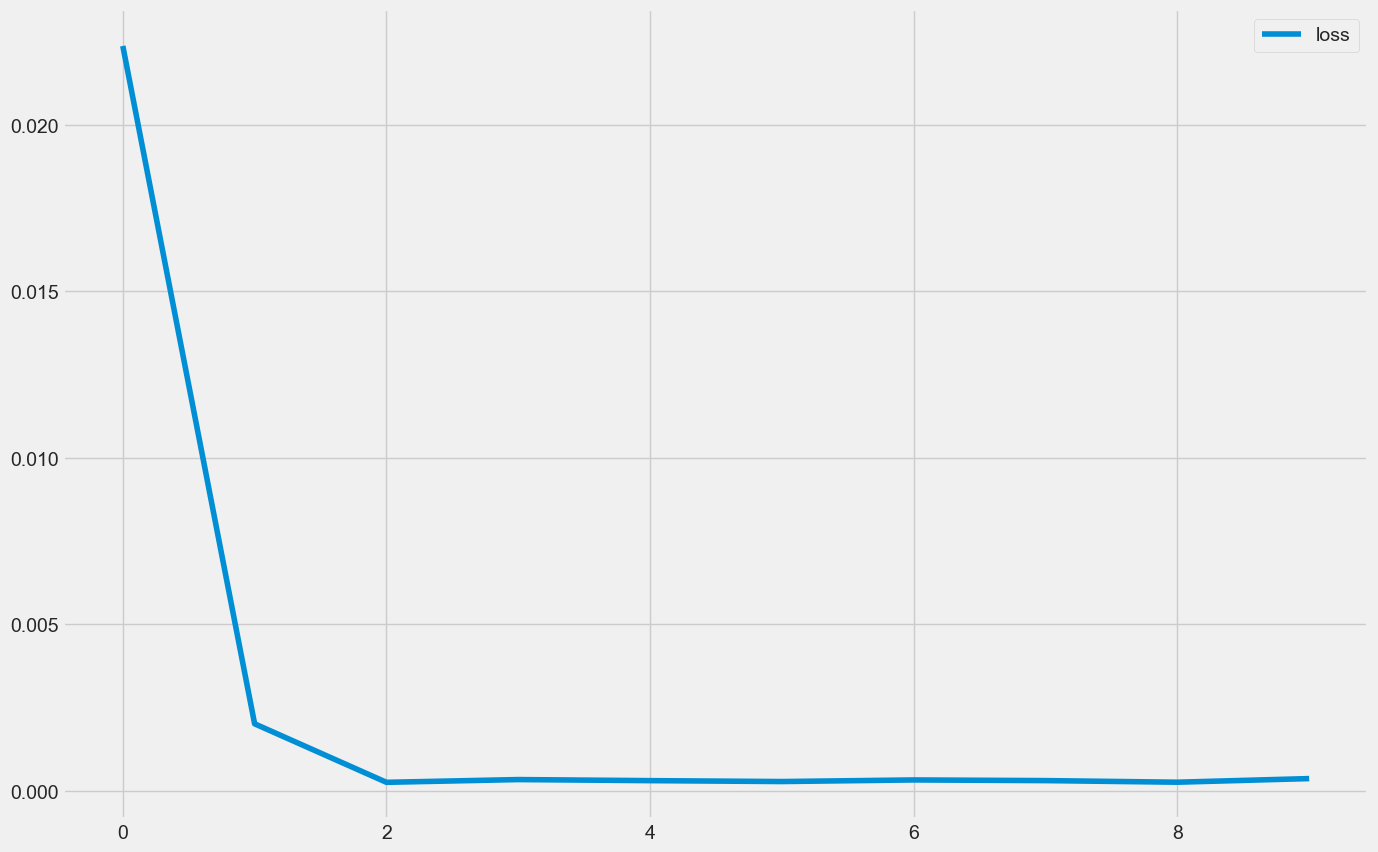

In [49]:
plot_loss(history)

### Prediction

In [50]:
# Scaling
inputs = sc.transform(test_set.reshape(-1, 1))

In [51]:
# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(-1, n_steps, features)

In [52]:
# Prediction
predicted_stock_price = model_rnn.predict(X_test)
# Inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

15/15 [==============================] - 0s 2ms/step


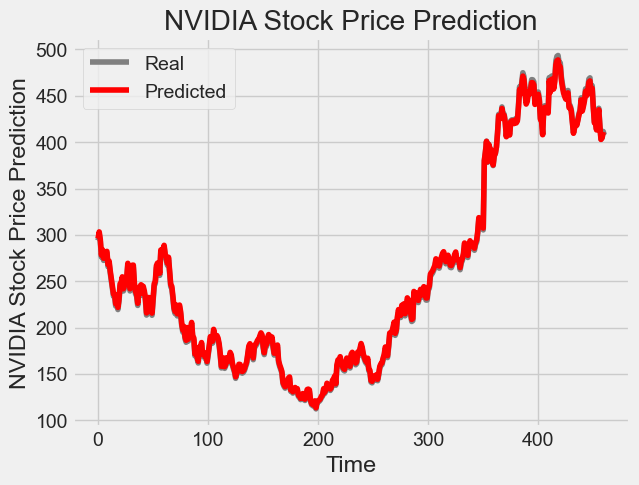

In [53]:
plot_predictions(test_set, predicted_stock_price, "NVIDIA Stock Price Prediction")

### Sequence Generation

In [54]:
steps_in_future = 25

In [55]:
def sequence_generation(dataset: pd.DataFrame, sc: MinMaxScaler, model:Sequential, steps_future: int):
    high_dataset = dataset.iloc[len(dataset) - len(test_set) - n_steps:]["High"]
    high_dataset = sc.transform(high_dataset.values.reshape(-1, 1))
    inputs = high_dataset[:n_steps]

    for _ in range(steps_future):
        curr_pred = model.predict(inputs[-n_steps:].reshape(-1, n_steps, features), verbose=0)
        inputs = np.append(inputs, curr_pred, axis=0)

    return sc.inverse_transform(inputs[n_steps:])

In [56]:
results = sequence_generation(dataset, sc, model_rnn, steps_in_future)

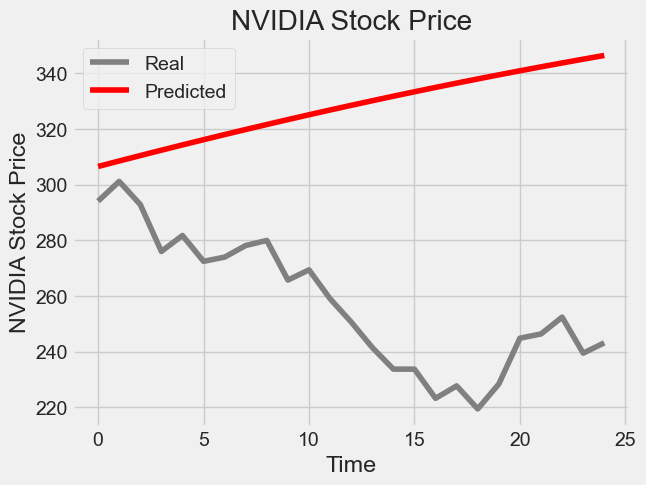

In [57]:
plot_predictions(test_set[:steps_in_future], results, "NVIDIA Stock Price")

## **LSTM**